# IMDB Visualization Using BigQuery And PySpark

### Dataset
This IMDb dataset has a collection of movies,tv_series with information on their titles, genres, runtime, ratings, and release years. The dataset includes a mix of genres, including horror, comedy, and documentary, and includes movies released as far back as the early 1900s. Some of the entries have missing information, such as the runtime or release year, which may limit the dataset's usefulness for some analyses. Overall, this dataset could be useful for exploring trends in movie genres and ratings over time, or for building models to predict movie success based on genre or other features.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset/imdb.csv


## BigQuery
The Google Big Query API allows for accessing and extracting large amounts of data that would be difficult to handle on a personal computer or non-distributed system. 
We extracted the IMDB dataset from BigQuery

In [2]:
# from google.cloud import bigquery
# from google.oauth2 import service_account
# import json

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value = user_secrets.get_secret("key")

# credentials = service_account.Credentials.from_service_account_info(
#     json.loads(secret_value)
# )

## Create a "Client" object
# client = bigquery.Client(credentials=credentials)

BackendError: Unexpected response from the service. Response: {'errors': ['No user secrets exist for kernel id 36350362 and label key.'], 'error': {'code': 5, 'details': []}, 'wasSuccessful': False}.

In [4]:
# import pandas as pd
# # from google.cloud import bigquery

### Set up the query
# query = '''
#         SELECT title_type,primary_title,genres,runtime_minutes,
#         num_votes,average_rating,start_year
#         FROM `bigquery-public-data.imdb.title_ratings` AS rating 
#         JOIN `bigquery-public-data.imdb.title_basics` AS title
#         ON rating.tconst=title.tconst
#         '''

# # # Run the query and save the results to a DataFrame
# datafirst = client.query(query)

# ds = [(row.title_type,row.primary_title,row.genres,row.runtime_minutes,
#         row.num_votes,row.average_rating,row.start_year)
#       for row in datafirst]

# # print(ds)
# df = pd.DataFrame(ds,columns=['title_type','primary_title','genres','runtime_minutes',
#                               'num_votes','average_rating','start_year'])


# df.head()
# df.to_csv('imdb_data.csv', index = False, encoding='utf-8')

NameError: name 'client' is not defined

### Importing libraries 

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
import os
import json

### Using PySpark to Transform and Visualize data

In [7]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 15.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=fdb6e44dffc82a9ee17e33e59fc778622ae2b0c8dc9edd1e949e796dd9e14698
  Stored in directory: /root/.cache/pip/wheels/5a/54/9b/a89cac960efb57c4c35d41cc7c9f7b80daa21108bc376339b7
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Note: you may need to restart the kernel to use updated packages.


In [44]:
#using pyspark as our dataframe for big data
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import explode, split, count, desc

In [79]:
# Creating a SparkSession object
spark = SparkSession.builder.appName('imdb_viz').getOrCreate()

# Importing a CSV file as a DataFrame
df = spark.read.csv('/kaggle/input/imdb-dataset/imdb.csv', header=True, inferSchema=True)

In [10]:
df.show(10)

+----------+--------------------+--------------------+---------------+---------+--------------+----------+
|title_type|       primary_title|              genres|runtime_minutes|num_votes|average_rating|start_year|
+----------+--------------------+--------------------+---------------+---------+--------------+----------+
|   tvShort|     The Three Bears|               Short|           null|        8|           7.6|    1938.0|
|   tvShort|           El coyote|             Western|           27.0|        8|           5.6|    1957.0|
|   tvShort|Shelagh Delaney's...|   Documentary,Short|           15.0|       50|           7.1|    1960.0|
|   tvShort|          How Swived|        Comedy,Short|            6.0|       12|           6.6|    1962.0|
|   tvShort|       Skinny Minnie|     Animation,Short|            5.0|        5|           8.4|    1967.0|
|   tvShort|Bema pamieci raps...|         Music,Short|           13.0|        5|           6.4|    1969.0|
|   tvShort|            Antoshka|Anim

In [11]:
summary = df.describe()
summary.show()

+-------+----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+
|summary|title_type|       primary_title|              genres|     runtime_minutes|          num_votes|      average_rating|          start_year|
+-------+----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+
|  count|   1292930|             1292930|             1273408|              927142|            1292915|             1292929|             1292671|
|   mean|      null|                 NaN|                null|   56.11815794157143| 1040.1015785309276|   6.949938704969477|   2002.111463646146|
| stddev|      null|                 NaN|                null|  113.70437535726663|  17400.80114611236|  1.3864798451529847|   22.96546350915823|
|    min|     movie|              !Next?| "" Gender Noncon...| ""Blisster Sister""| ""Breaking Bliss""| ""Blisstersweet ...|

In [ ]:
df.printSchema()

In [20]:
from pyspark.sql.types import IntegerType,FloatType
df = df.withColumn("num_votes", df["num_votes"].cast(IntegerType())


In [21]:
df = df.withColumn("average_rating", df["average_rating"].cast('float'))

In [32]:
df = df.withColumn("runtime_minutes", df["runtime_minutes"].cast(IntegerType()))

In [23]:
df.printSchema()

root
 |-- title_type: string (nullable = true)
 |-- primary_title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- runtime_minutes: integer (nullable = true)
 |-- num_votes: float (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- start_year: string (nullable = true)



#### Taking only Movies Data

In [33]:
movie_df = df.filter(df["title_type"] == "movie")

movie_df.show(10)

+----------+--------------------+--------------------+---------------+---------+--------------+----------+
|title_type|       primary_title|              genres|runtime_minutes|num_votes|average_rating|start_year|
+----------+--------------------+--------------------+---------------+---------+--------------+----------+
|     movie|        This is Life|              Comedy|             75|      9.0|           8.0|      null|
|     movie|         Sesha Raati|              Horror|           null|      5.0|           9.0|      null|
|     movie|            Vampires|              Horror|             80|     76.0|           4.0|      null|
|     movie|The Great 14th: T...|         Documentary|             82|    152.0|           9.0|      null|
|     movie|Haikus on a Plum ...|Biography,Documen...|             73|      9.0|           8.0|      null|
|     movie|The Republican Na...|         Documentary|             53|     41.0|           5.0|    1900.0|
|     movie|      May Day Parade|    

## Visualizations

## Bar chart of the top 10 genres by frequency

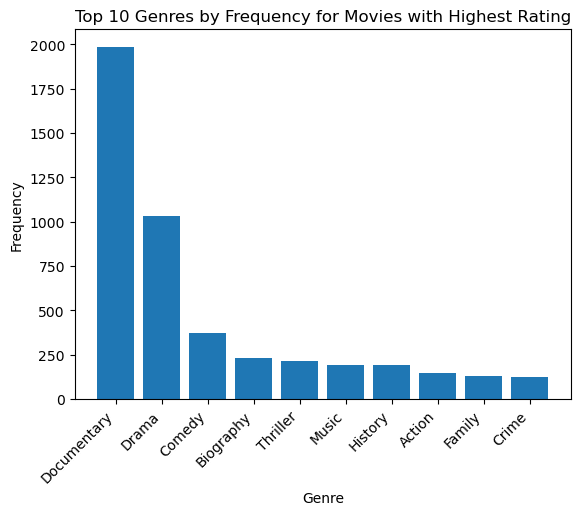

In [34]:
# Filter the DataFrame to only include movies with a rating within the top 1000
top_rated_movies = movie_df.filter(movie_df["average_rating"] >= 9.0).orderBy("average_rating", ascending=False)

# Split the genres column into separate rows and filter for movies only
genre_df = top_rated_movies.selectExpr("explode(split(genres, ',')) as genre").filter(col("genre") != "")

# Count the frequency of each genre
genre_counts = genre_df.groupBy("genre").count().orderBy("count", ascending=False).limit(10).toPandas()

# Plot the bar chart
plt.bar(genre_counts["genre"], genre_counts["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.title("Top 10 Genres by Frequency for Movies with Highest Rating")
plt.show()



## Box plot of the distribution of runtime_minutes for top rated movies by genre:


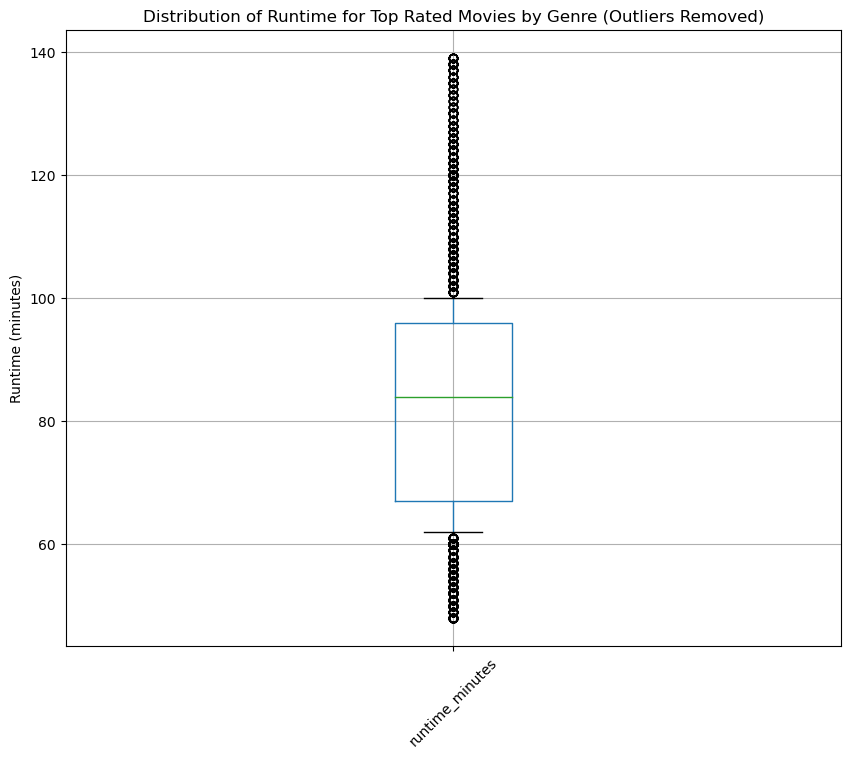

In [39]:
# # Split the genres column into separate rows
genre_df = top_rated_movies.selectExpr("primary_title", "explode(split(genres, ',')) as genre", "cast(runtime_minutes as float) as runtime_minutes")

# # Plot the box plot with adjusted whiskers
# genre_df.dropna().toPandas().boxplot(column="runtime_minutes", rot=45, figsize=(10,8), whis=(20,80))
# plt.ylabel("Runtime (minutes)")
# plt.title("Distribution of Runtime for Top Rated Movies by Genre")
# plt.show()

# Set the lower and upper bounds for the runtime values
lower_bound = genre_df.approxQuantile("runtime_minutes", [0.05], 0.01)[0]
upper_bound = genre_df.approxQuantile("runtime_minutes", [0.95], 0.01)[0]

# Filter the DataFrame to only include rows within the runtime range
filtered_df = genre_df.filter((col("runtime_minutes") >= lower_bound) & (col("runtime_minutes") <= upper_bound))

# Plot the box plot with adjusted whiskers and filtered data
filtered_df.dropna().toPandas().boxplot(column="runtime_minutes", rot=45, figsize=(10,8), whis=(20,80))
plt.ylabel("Runtime (minutes)")
plt.title("Distribution of Runtime for Top Rated Movies by Genre (Outliers Removed)")
plt.show()



## Visualize the distribution of genres using a pie chart

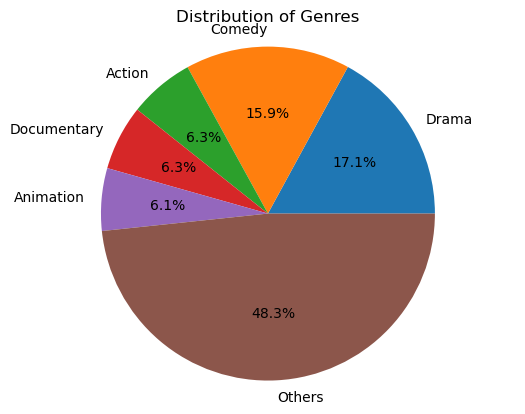

In [46]:
# Split the genres column into separate rows
genre_df = df.select(explode(split(col("genres"), ",")).alias("genre"))

# Count the frequency of each genre
genre_counts = genre_df.groupBy("genre").count().toPandas()

# Sort the genres by frequency in descending order
genre_counts = genre_counts.sort_values(by="count", ascending=False)

# Keep only the top 5 genres and group the rest into a single slice called "Others"
top_5_genres = genre_counts.head(5)
other_genres_count = genre_counts["count"][5:].sum()
other_genres = pd.DataFrame({"genre": ["Others"], "count": [other_genres_count]})
genre_counts = pd.concat([top_5_genres, other_genres])

# Plot the pie chart
plt.pie(genre_counts["count"], labels=genre_counts["genre"], autopct="%1.1f%%")
plt.axis("equal")
plt.title("Distribution of Genres")
plt.show()


## Runtime by Year
We can explore how the runtime of movies has changed over the years. We can plot a line chart to see the trend in movie runtime.

23/03/23 05:02:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 05:02:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 05:02:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/03/23 05:02:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 05:02:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 05:02:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 05:02:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 05:02:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 05:02:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


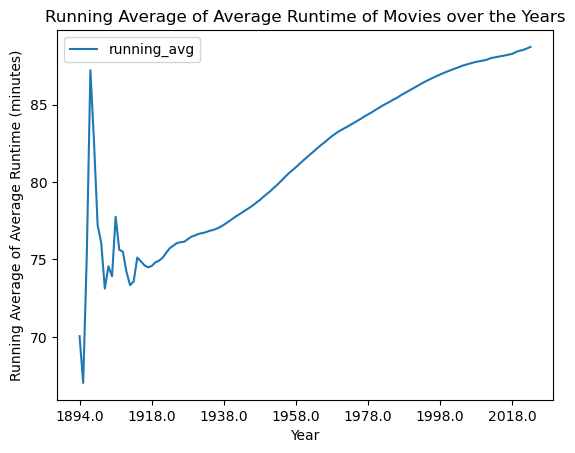

In [48]:
# Select necessary columns
runtime_year_df = movie_df.select("start_year", "runtime_minutes")

# Group by year and calculate the average runtime
avg_runtime_df = runtime_year_df.groupBy("start_year").agg(F.avg("runtime_minutes").alias("avg_runtime"))

# Sort the data by start_year
avg_runtime_df = avg_runtime_df.orderBy("start_year")

# Calculate the running average of average runtime
avg_runtime_df = avg_runtime_df.withColumn("running_avg", F.avg("avg_runtime").over(Window.orderBy("start_year").rowsBetween(Window.unboundedPreceding, Window.currentRow)))

# Plot the trend of running average of average runtime over the years
avg_runtime_df.dropna().toPandas().plot(kind='line', x='start_year', y='running_avg')
plt.xlabel("Year")
plt.ylabel("Running Average of Average Runtime (minutes)")
plt.title("Running Average of Average Runtime of Movies over the Years")
plt.show()


## Bar Chart of Title Type

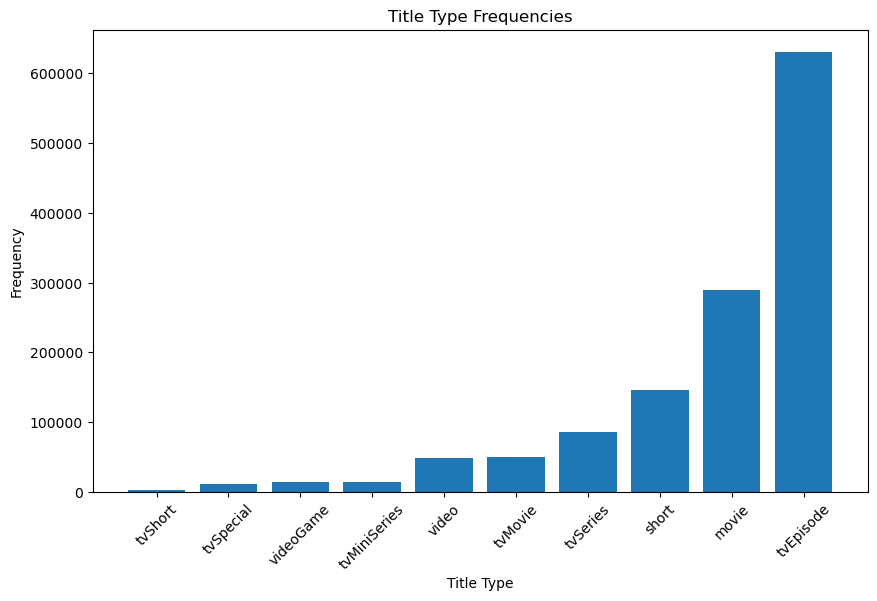

In [52]:
import matplotlib.pyplot as plt

# Group by title type and calculate the count of each title type
title_type_counts = df.groupBy('title_type').agg(count('*').alias('count')).orderBy('count')

# Convert to a pandas DataFrame
title_type_counts_pd = title_type_counts.toPandas()

# Set the figure size and plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(title_type_counts_pd['title_type'], title_type_counts_pd['count'])
ax.set_title('Title Type Frequencies')
ax.set_xlabel('Title Type')
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', labelrotation=45)

plt.show()


## Scatter Plot

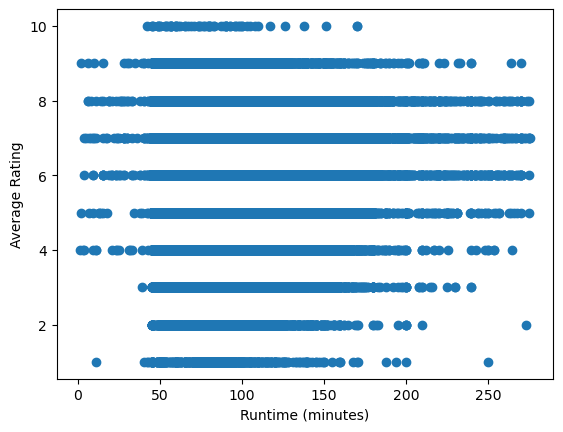

In [54]:
import numpy as np

# Filter out rows with missing runtime or average rating values
filtered_df = movie_df.filter(col("runtime_minutes").isNotNull() & col("average_rating").isNotNull())

# Calculate the mean and standard deviation of runtime
mean_runtime = filtered_df.agg({"runtime_minutes": "mean"}).collect()[0][0]
std_runtime = filtered_df.agg({"runtime_minutes": "stddev"}).collect()[0][0]

# Filter out runtimes that are outside 1 standard deviation from the mean
filtered_df = filtered_df.filter((col("runtime_minutes") >= mean_runtime - std_runtime) & (col("runtime_minutes") <= mean_runtime + std_runtime))

# Create a scatter plot of runtime vs. average rating
plt.scatter(filtered_df.select("runtime_minutes").rdd.flatMap(lambda x: x).collect(),
            filtered_df.select("average_rating").rdd.flatMap(lambda x: x).collect())
plt.xlabel("Runtime (minutes)")
plt.ylabel("Average Rating")
plt.show()


## Stacked Bar Chart of Genres by Title Type

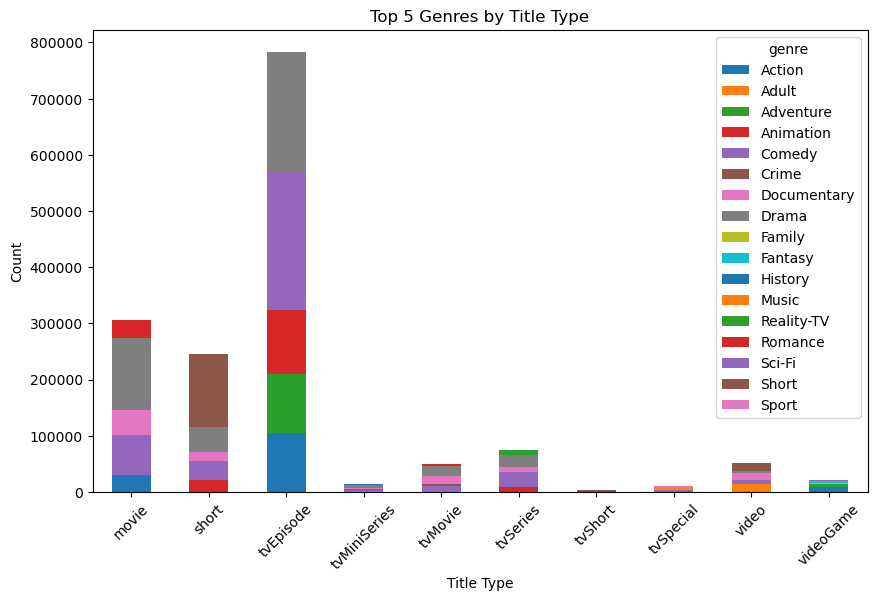

In [55]:


# Group by title type and genre, count the number of records, and order by title type and count
genres_by_title_type = df.select('title_type', explode(split('genres', ',')).alias('genre')) \
                        .groupBy('title_type', 'genre') \
                        .agg(count('*').alias('count')) \
                        .orderBy('title_type', desc('count'))

# Window function to rank genres by count within each title type
window = Window.partitionBy('title_type').orderBy(desc('count'))
genres_by_title_type = genres_by_title_type.withColumn('rank', F.row_number().over(window))

# Select only the top 5 genres for each title type
genres_by_title_type = genres_by_title_type.filter(genres_by_title_type.rank <= 5)

# Convert the resulting DataFrame to a Pandas DataFrame
genres_by_title_type_pd = genres_by_title_type.toPandas()

# Pivot the data and plot a stacked bar chart
ax = genres_by_title_type_pd.pivot(index='title_type', columns='genre', values='count').plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Top 5 Genres by Title Type')
plt.xlabel('Title Type')
plt.ylabel('Count')

# Rotate the x-axis labels to make them slanted
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.show()


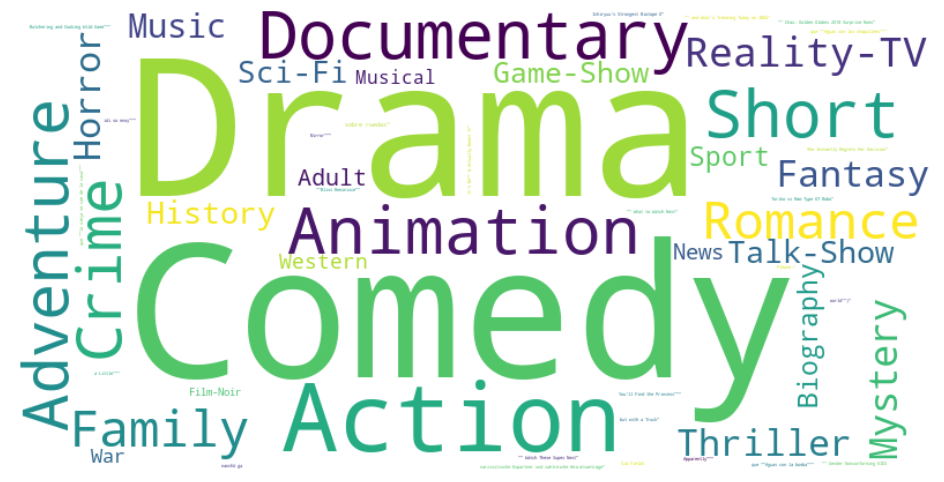

In [56]:
from pyspark.sql.functions import split, explode
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Extract all genres into a single list
genres_list = df.select(explode(split('genres', ',')).alias('genre')).rdd.map(lambda row: row.genre).collect()

# Create a dictionary with the count of each genre
genres_count = {}
for genre in genres_list:
    if genre in genres_count:
        genres_count[genre] += 1
    else:
        genres_count[genre] = 1

# Create the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genres_count)

# Plot the wordcloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
